![](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

# Parallel Computing with Earthdata and Dask: An Example of Replicating a Function Over Many Files

#### *Authors: Dean Henze and Jinbo Wang, NASA JPL PO.DAAC*

## Summary

A previous notebook covered basic use of Dask for parallel computing with Earthdata. This included the case where we have a function we wish to replicate over many files, represented by the schematic below.

<img src="../../images/basicdask_schematic1.png" alt="sch1" width="500"/>

In a previous notebook, a toy example was used to demonstrate this basic functionality using a local cluster and `dask.delayed()`. In this notebook, we expand that workflow to a more complex analysis, representing something closer to a real-world use-case.

The analysis will generate global maps of spatial correlation between sea surface temperature (SST) and sea surface height (SSH). The analysis uses PO.DAAC hosted, gridded SSH and SST data sets:
* MEaSUREs gridded SSH Version 2205: 0.17° x 0.17° resolution, global map, one file per 5-days, https://doi.org/10.5067/SLREF-CDRV3
* GHRSST Level 4 MW_OI Global Foundation SST, V5.0: 0.25° x 0.25° resolution, global map, daily files, https://doi.org/10.5067/GHMWO-4FR05

The time period of overlap between these data sets is 1998 – 2020, with 1808 days in total overlapping. For each pair of SST, SSH files on these days, compute a map of spatial correlation between them, where the following method is used at each gridpoint:

<img src="../../images/schematic_sst-ssh_corr.png" alt="sch_sst-ssh-corr" width="1000"/>

This notebook will first define the functions to read in the data and perform the computations, then test them on a single file. Next a smaller parallel computation will be performed on all pairs of files in 2018 (73 pairs in total), reducing what would have otherwise taken hours to minutes instead. Finally, an optional section will demonstrate what was used to perform the full computation on all 1808 pairs of files at 0.25 degree resolution. 

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook
* **Earthdata login account:** An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. 
* **Compute environment:** This notebook can technically be run either in the cloud (AWS instance running in us-west-2), or on a local compute environment (e.g. laptop, server). However, running in the cloud is recommended, since it is unlikely that a laptop has the power to replicate the compute times we quote here. If running in a local environment, the number of workers spun up Section 4 will likely need to be decreased.
* **VM type:** For running in AWS (recommended), we used C7i instances, which are "compute-optimized" VM's well-suited to the particular computations performed here (more on this later). Since the cost per hour of these instances go up in size, we recommend the following workflow to explore this notebook.
> 1. Start by running Sections 1 - 3 in a low cost c7i.2xlarge instance (fractions of a $1 per hour).
> 2. Parallel computations start in Section 4. For this, we ran Sections 1-4 with a c7i.24xlarge. At the time this notebook was written, this VM type took 7-10 minutes to run the computations, and cost ~\\$4/hr. You can run a smaller, less expensive VM type, but will need to change one line of code in Section 4.
> 3. For Optional Section 5, we ran using a c7i.24xlarge, although you could try running it with  a c7i.48xlarge (double the vCPUs and double the cost).

#### Prerequisite knowledge
* Please make sure you are comfortable with the [notebook on Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) and all prerequisites therein.

#### Learning outcomes
This notebook demonstrates how to use `dask.delayed()` with a local cluster on an analysis mirroring what someone might want to do in a real-world setting. As such, you will get better insight on how to apply this workflow to your own analysis. Further, this notebook touches briefly on choosing VM types, which may be many user's first introduction to the topic. 

## Import packages

We ran this notebook in a Python `3.12.3` environment. The minimal working install we used to run this notebook from a clean environment was:

*With pip:*
```
pip install xarray==2024.1.0 numpy==1.26.3 h5netcdf==1.3.0 scipy==1.11.4 "dask[complete]"==2024.5.0 earthaccess==0.9.0 matplotlib==3.8.0 jupyterlab
```
*or with conda:*
```
conda install xarray==2024.1.0 numpy==1.26.3 h5netcdf==1.3.0 scipy==1.11.4 "dask[complete]"==2024.5.0 earthaccess==0.9.0 matplotlib==3.8.0 jupyterlab
```
Note that the versions are important, specifially for the science / math packages - when running newer versions of xarray, scipy, and numpy, we got some strange results. 

In [1]:
# Built in packages
import time
import sys
import os
import shutil

# Math / science packages
import xarray as xr
import numpy as np
from scipy.optimize import leastsq

# Plotting packages
from matplotlib import pylab as plt
%matplotlib inline

# Cloud / parallel computing packages
import earthaccess
import dask
from dask.distributed import Client
from dask import delayed
import dask.array as da
import multiprocessing

## 1. Define functions

The main function implemented is `spatial_corrmap()`, which will return the map of correlations as a 2D array. The other functions below are called by `spatial_corrmap()`.  

In [2]:
def load_sst_ssh(gran_ssh, gran_sst):
    """
    Return SLA and SST variables for a single file each of the 
    SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and MW_OI-REMSS-L4-GLOB-v5.0 
    collections, respectively, returned as xarray.DataArray's. Input args are granule info 
    (earthaccess.results.DataGranule object's) for each collection.  
    """
    earthaccess.login(strategy="environment") # Confirm credentials are current
    
    # Get SLA and SST variables, loaded fully into local memory:
    ssh = xr.load_dataset(earthaccess.open([gran_ssh], provider='POCLOUD')[0])['SLA'][0,...]
    sst = xr.load_dataset(earthaccess.open([gran_sst], provider='POCLOUD')[0])['analysed_sst'][0,...]

    return ssh, sst

In [3]:
def spatialcorr(x, y, p1, p2):
    """
    Correlation between two 2D variables p1(x, y), p2(x, y), over the domain (x, y). Correlation is 
    computed between the anomalies of p1, p2, where anomalies for each variables are the deviations from 
    respective linear 2D surface fits.
    """
    # Compute anomalies:
    ssha, _ = anomalies_2Dsurf(x, y, p1) # See function further down.
    ssta, _ = anomalies_2Dsurf(x, y, p2)
    
    # Compute correlation coefficient:
    a, b = ssta.flatten(), ssha.flatten()
    if ( np.nansum(abs(a))==0 ) or ( np.nansum(abs(b))==0 ): # For cases where all anomalies are 0, the correlation 
        # should be 0. Numpy computes this correctly but throws a lot of warnings. So instead, we manually append 0.
        return 0
    else:
        return np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))


def anomalies_2Dsurf(x, y, p):
    """
    Return anomalies for a 2D variable. Anomalies are computed as the deviations of each 
    point from a bi-linear 2D surface fit to the data (using scipy).
    
    Inputs
    ------
    x, y: 1D array-like.
        Independent vars (likely the lon, lat coordinates).
    p: 2D array-like, of shape (len(y), len(x)).
        Dependent variable. 2D surface fit will be to p(x, y).
    
    Returns
    ------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).
    """
    # Functions to (1) output a 2D surface and (2) output the difference between 2D data and the computed surface:
    def surface(c,x0,y0): # Takes independent vars and poly coefficients
        a,b,c=c
        return a + b*x0 + c*y0
    
    def err(c,x0,y0,p): # Takes independent/dependent vars and poly coefficients
        a,b,c=c
        return p - (a + b*x0 + c*y0 )


    # Prep arrays and remove NAN's:
    xx, yy = np.meshgrid(x, y)
    xf, yf, pf = xx.flatten(), yy.flatten(), p.flatten()
    msk=~np.isnan(pf)
    xf, yf, pf = xf[msk], yf[msk], pf[msk]

    
    # Initial values of polynomial coefficients to start fitting algorithm off with:
    dpdx=(pf.max()-pf.min())/(xf.max()-xf.min())
    dpdy=(pf.max()-pf.min())/(yf.max()-yf.min())
    c = [pf.mean(),dpdx,dpdy]

    
    # Fit and compute anomalies:
    coef = leastsq(err,c,args=(xf,yf,pf))[0]
    vm = surface(coef, xx, yy) # mean surface
    va = p - vm # anomalies
    return va, vm

In [4]:
def spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=None, lons=None, f_notnull=0.5):
    """
    Get a 2D map of SSH-SST spatial correlation coefficients, for one each of the 
    SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and MW_OI-REMSS-L4-GLOB-v5.0 collections. 
    At each gridpoint, the spatial correlation is computed over a lat, lon window of size 
    2*lat_halfwin x 2*lon_halfwin. Correlation is computed from the SSH, SST anomalies, which are computed 
    in turn as the deviations from a fitted 2D surface over the window.
    
    Inputs
    ------
    grans: 2-tuple of earthaccess.results.DataGranule objects
        Granule info for the SSH, SST files (in that order). These objects contain https and S3 locations.
    lat_halfwin, lon_halfwin: floats
        Half window size in degrees for latitude and longitude dimensions, respectively.
    lats, lons: None or 1D array-like
        Latitude, longitude gridpoints at which to compute the correlations. 
        If None, will use the SSH grid.
    f_notnull: float between 0-1 (default = 0.5)
        Threshold fraction of non-NAN values in a window in order for the correlation to be computed,
        otherwise NAN is returned for that grid point. For edge cases, 'ghost' elements are counted as NAN.

    Returns
    ------
    coef: 2D numpy array
        Spatial correlation coefficients.
    
    lats, lons: 1D numpy arrays.
        Latitudes and longitudes creating the 2D grid that 'coef' was calculated on.
    """    
    # Load datafiles, convert SST longitude to (0,360), and interpolate SST to SSH grid:    
    ssh, sst = load_sst_ssh(*grans)
    sst = sst.roll(lon=len(sst['lon'])//2)
    sst['lon'] = sst['lon']+180
    sst = sst.interp(lon=ssh['Longitude'], lat=ssh['Latitude'])

    
    # Compute windows size and threshold number of non-nan points:
    dlat = (ssh['Latitude'][1]-ssh['Latitude'][0]).item()
    dlon = (ssh['Longitude'][1]-ssh['Longitude'][0]).item()
    nx_win = 2*round(lon_halfwin/dlon)
    ny_win = 2*round(lat_halfwin/dlat)
    n_thresh = nx_win*ny_win*f_notnull


    # Some prep work for efficient identification of windows where number of non-nan's < threshold:
        # Map of booleans for sst*ssh==np.nan
    notnul = (sst*ssh).notnull() 
        # Combine map and sst, ssh data into single Dataset for more efficient indexing:
    notnul = notnul.rename("notnul") # Needs a name to merge
    mergeddata = xr.merge([ssh, sst, notnul], compat="equals")
     

    # Compute spatial correlations over whole map:
    coef = []
    
    if lats is None:
        lats = ssh['Latitude'].data
        lons = ssh['Longitude'].data
    
    for lat_cen in lats:
        for lon_cen in lons:

            # Create window for both sst and ssh with xr.sel:
            lat_bottom = lat_cen - lat_halfwin
            lat_top = lat_cen + lat_halfwin
            lon_left = lon_cen - lon_halfwin
            lon_right = lon_cen + lon_halfwin
            data_win = mergeddata.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
    
            # If number of non-nan values in window is less than threshold 
            # value, append np.nan, else compute correlation coefficient:
            n_notnul = data_win["notnul"].sum().item()
            if n_notnul < n_thresh:
                coef.append(np.nan)
            else:
                c = spatialcorr(data_win['Longitude'], data_win['Latitude'], data_win['SLA'].data, data_win['analysed_sst'].data)
                coef.append(c)
    
    return np.array(coef).reshape((len(lats), len(lons))), np.array(lats), np.array(lons)

## 2. Get all matching pairs of SSH, SST files for 2018

The `spatial_corrmap()` function takes as one of its arguments a 2-tuple of `earthaccess.store.EarthAccessFile` objects, one each for SSH and SST (recall that `earthaccess.store.EarthAccessFile` objects are returned from a call to `earthaccess.open()`, and are passed to `Xarray`). This section will retrieve pairs of these objects for all SSH, SST data in 2018 on days where the data sets overlap. 

In [ ]:
earthaccess.login()

In [6]:
## Granule info for all files in 2018:
dt2018 = ("2018-01-01", "2018-12-31")
grans_ssh = earthaccess.search_data(short_name="SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205", temporal=dt2018)
grans_sst = earthaccess.search_data(short_name="MW_OI-REMSS-L4-GLOB-v5.0", temporal=dt2018)

Granules found: 73
Granules found: 365


In [7]:
## File coverage dates extracted from filenames:
dates_ssh = [g['umm']['GranuleUR'].split('_')[-1][:8] for g in grans_ssh]
dates_sst = [g['umm']['GranuleUR'][:8] for g in grans_sst]
print(' SSH file days: ', dates_ssh[:8], '\n', 'SST file days: ', dates_sst[:8])

 SSH file days:  ['20180102', '20180107', '20180112', '20180117', '20180122', '20180127', '20180201', '20180206'] 
 SST file days:  ['20180101', '20180102', '20180103', '20180104', '20180105', '20180106', '20180107', '20180108']


In [8]:
## Separate granule info for dates where there are both SSH and SST files:
grans_ssh_analyze = []
grans_sst_analyze = []
for j in range(len(dates_ssh)):
    if dates_ssh[j] in dates_sst:
        grans_ssh_analyze.append(grans_ssh[j])
        grans_sst_analyze.append(grans_sst[dates_sst.index(dates_ssh[j])])

**The result is two lists of `earthaccess.results.DataGranule` objects, where the ith element of the SSH, SST lists contain granule info for the respective data sets on the same day:**

In [9]:
print(grans_ssh_analyze[0]['umm']['CollectionReference']['ShortName'], ':', len(grans_ssh_analyze), 'granules')
print([g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'] for g in grans_ssh_analyze[:4]])
print(grans_sst_analyze[0]['umm']['CollectionReference']['ShortName'], ':', len(grans_sst_analyze), 'granules')
print([g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'] for g in grans_sst_analyze[:4]])

SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 : 73 granules
['2018-01-02T00:00:00.000Z', '2018-01-07T00:00:00.000Z', '2018-01-12T00:00:00.000Z', '2018-01-17T00:00:00.000Z']
MW_OI-REMSS-L4-GLOB-v5.0 : 73 granules
['2018-01-02T00:00:00.000Z', '2018-01-07T00:00:00.000Z', '2018-01-12T00:00:00.000Z', '2018-01-17T00:00:00.000Z']


## 3. Test the computation on a pair of files, output on a coarse resolution grid

To verify the functions work, we test them on the first pair of files. To reduce computation time, we compute them for a 2 degree x 2 degree output grid for now.

In [10]:
# Compute spatial correlation map for 2 degree x 2 degree resolution and time it:
t1 = time.time()

lats = np.arange(-80, 80, 2)
lons = np.arange(0, 359, 2)
coef, lats, lons = spatial_corrmap((grans_ssh_analyze[0], grans_sst_analyze[0]), 3, 3, lats=lats, lons=lons, f_notnull=0.5)

t2 = time.time()
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds.")

Opening 1 granules, approx size: 0.01 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Opening 1 granules, approx size: 0.0 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Total computation time = 21.34 seconds.


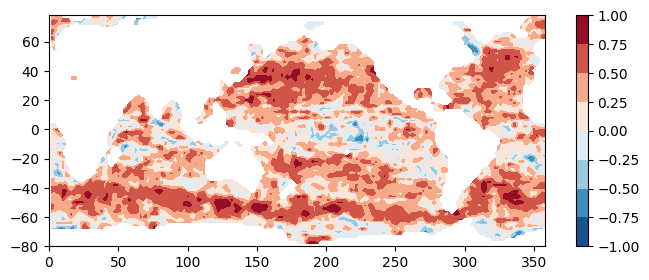

In [11]:
## Plot the results:
plt.figure(figsize=(8,3))
plt.contourf(lons, lats, coef, cmap='RdBu_r')
plt.colorbar()

### Estimation of computation time for higher resolution output and more files

The computation for one file computed on a 2 x 2 degree grid takes:

In [12]:
print(str(comptime) + " seconds.")

18.88 seconds.


then assuming linear scaling with number of gridpoints (reasonable since our top level function is a big for-loop), processing one file at 0.5 x 0.5 degree resolution would take:

In [13]:
eta_fullres_seconds = comptime*(2/0.5)*(2/0.5)
eta_fullres_minutes = round(eta_fullres_seconds/60)
print(str(eta_fullres_minutes) + " minutes.")

5 minutes.


and for the record over all of 2018 would take:

In [14]:
eta_allfiles_hrs = round( (len(grans_ssh)*eta_fullres_minutes)/60, 1 )
eta_allfiles_days = round(eta_allfiles_hrs/24, 2)
print(str(len(grans_ssh)) + " granules for 2018.")
print(str(eta_allfiles_hrs) + " hours = " + str(eta_allfiles_days) + " days.")

73 granules for 2018.
6.1 hours = 0.25 days.


## 4. Parallel computations with Dask

Sections 1 and 2 need to be run prior to this.

The previous section showed that analyzing a year's worth of data at 0.5 x 0.5 degree output resolution would take hours. In this section, we use `dask.delayed()` and a local cluster to complete this task in 7 - 20 minutes, depending on the VM type used. 

First, define a wrapper function which calls `spatial_corrmap()` for a pair of SSH, SST files and saves the output to a netCDF file. We will parallelize this function rather than `spatial_corrmap()`:

In [15]:
def corrmap_tofile(grans, dir_results="./", lat_halfwin=3, lon_halfwin=3, lats=None, lons=None, f_notnull=0.5):
    """
    Calls spatial_corrmap() for a pair of SSH, SST granules and saves the results to a netCDF file.
    """
    coef, lats, lons = spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=lats, lons=lons, f_notnull=0.5)
    date = grans[0]['umm']['GranuleUR'].split("_")[-1][:8] # get date from SSH UR.
    corrmap_da = xr.DataArray(data=coef, dims=["lat", "lon"], coords=dict(lon=lons, lat=lats), name='corr_ssh_sst')
    corrmap_da.to_netcdf(dir_results+"spatial-corr-map_ssh-sst_" + date + ".nc")
    return

Next, some prep work:

In [16]:
# All output will be saved to this local directory:
dir_results = "results/"
os.makedirs(dir_results, exist_ok=True)

# Latitudes, longitudes of output grid at 0.5 degree resolution:
lats = np.arange(-80, 80, 0.5)
lons = np.arange(0, 359, 0.5)

Start up the cluster. We used a c7i.24xlarge EC2 instance type, which has 96 vCPU's, and therefore we are able to start up 73 workers. If you use a smaller instance type in the C7i series, change the `n_workers` arg as needed.

In [ ]:
client = Client(n_workers=73, threads_per_worker=1)
print(client.cluster)
print(client.dashboard_link)

This block of code will give each worker our EDL credentials (even though we logged in with `earthaccess()` this is necessary to get creds to each worker):

In [18]:
def auth_env(auth): # this gets executed on each worker
    os.environ["EARTHDATA_USERNAME"] = auth["EARTHDATA_USERNAME"]
    os.environ["EARTHDATA_PASSWORD"] = auth["EARTHDATA_PASSWORD"]
    
_ = client.run(auth_env, auth=earthaccess.auth_environ())

then setup the parallel computations and run! (At the time this notebook was written, `earthaccess` produces a lot of output each time a file is opened, and so the output from this cell is long):

In [ ]:
t1 = time.time()

# Process granules in parallel using Dask:
grans_2tuples = list(zip(grans_ssh_analyze, grans_sst_analyze))
corrmap_tofile_parallel = delayed(corrmap_tofile)
tasks = [
    corrmap_tofile_parallel(g2, dir_results="results/", lats=lats, lons=lons, f_notnull=0.5) 
    for g2 in grans_2tuples[:]
    ]                     # Sets up the computations (relatively quick)
_ = da.compute(*tasks)    # Performs the computations (takes most of the time)

t2 = time.time()

In [20]:
## What was the total computation time?
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds = " + str(comptime/60) + " minutes.")

Total computation time = 451.97 seconds = 7.5328333333333335 minutes.


### Test plots

**Colormaps of first three files**

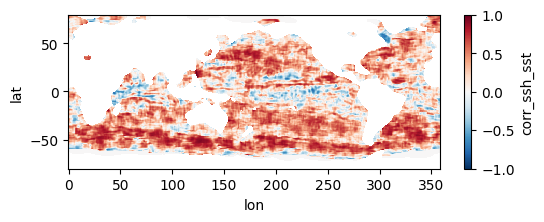

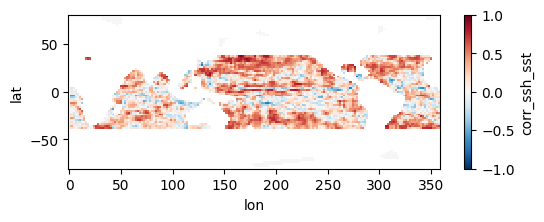

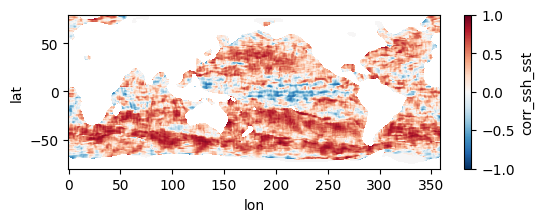

In [22]:
fns_results = [dir_results + f for f in os.listdir(dir_results) if f.endswith("nc")]
for fn in fns_results[:3]:
    testfile = xr.open_dataset(fn)
    testfile["corr_ssh_sst"].plot(figsize=(6,2), vmin=-1, vmax=1, cmap='RdBu_r')
    testfile.close()

**Colormap of mean correlation map for all files**

In [23]:
test_allfiles = xr.open_mfdataset(fns_results, combine='nested', concat_dim='dummy_time')
test_allfiles["corr_ssh_sst"]

<xarray.DataArray 'corr_ssh_sst' (dummy_time: 121, lat: 321, lon: 718)>
dask.array<concatenate, shape=(121, 321, 718), dtype=float64, chunksize=(1, 321, 718), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 356.5 357.0 357.5 358.0 358.5
  * lat      (lat) float64 -80.0 -79.5 -79.0 -78.5 -78.0 ... 78.5 79.0 79.5 80.0
Dimensions without coordinates: dummy_time

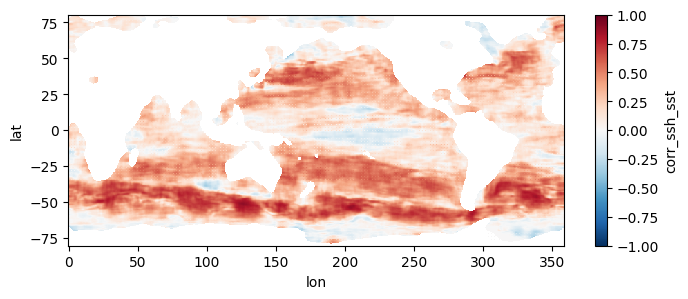

In [24]:
test_allfiles["corr_ssh_sst"].mean(dim='dummy_time').plot(figsize=(8,3), vmin=-1, vmax=1, cmap='RdBu_r')
test_allfiles.close()

## Other notes

* **Why C7i instance types?** Notice that the size of our data files are relatively small, about 10 MB per pair of files. Yet, the computations we perform on them are complex enough that it takes ~5-7 minutes per pair of files (and this is only at 0.5 degree output resolution, multiply this by 4x for the 0.25 degree resolution in Section 5!). This type of computation is referred to as "compute limited", because the limiting factor in the time for completion is churning through the computation itself. Contrast this to e.g. a "memory limited" computation, where perhaps the computation is simple but the size of each file is large (an example would be taking the global average of a MUR 0.01 degree file). As per [Amazon's page describing the different classes of EC2 types](https://aws.amazon.com/ec2/instance-types/), the C7i series are compute optimized, and therefore well suited to this problem. For a given amount of total memory in the VM, we get a lot of high performance processors, and each one can churn through the computations per pair of SST-SSH files. *Please take this explanation with a grain of salt. The author is not a computer scientist and is learning these complex topics himself!*

## 5. Optional: Parallel computation on full record at 0.25 degree resolution

Only Section 1 needs to be run prior to this. Sections 2-4 can be skipped.

This section mirrors the workflow of Section 4, but processes all 1808 pairs of files, spanning a little over two decades, at higher resolution. To get an estimate of how long this would take without parallel computing, you can re-run section 3 but replace a value of *0.5* for the `higher_res` variable with *0.25* (in the part where we estimate comp times). Trying this on a few machines, we get that it would take anywhere from 21 to 34 hours to process the record over a single year, which means for 22 years it would take 19 to 31 days to complete the entire record. When we used this code to run the computation in parallel on a c7i.24xlarge instance, computation took us instead ~10.5 hours and cost ~$45, obtaining the following mean map for the full record:

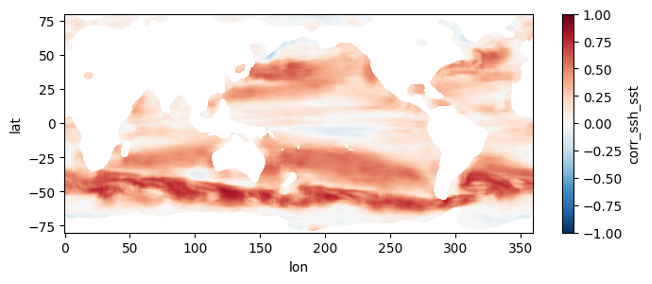

First, we duplicate most of the code in Section 2, this time getting granule info objects for the entire record:

In [25]:
earthaccess.login()

## Granule info for all files in both collections:
grans_ssh = earthaccess.search_data(short_name="SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205")
grans_sst = earthaccess.search_data(short_name="MW_OI-REMSS-L4-GLOB-v5.0")

## File coverage dates extracted from filenames:
dates_ssh = [g['umm']['GranuleUR'].split('_')[-1][:8] for g in grans_ssh]
dates_sst = [g['umm']['GranuleUR'][:8] for g in grans_sst]

## Separate granule info for dates where there are both SSH and SST files:
grans_ssh_analyze = []
grans_sst_analyze = []
for j in range(len(dates_ssh)):
    if dates_ssh[j] in dates_sst:
        grans_ssh_analyze.append(grans_ssh[j])
        grans_sst_analyze.append(grans_sst[dates_sst.index(dates_ssh[j])])

Granules found: 2207
Granules found: 9039


Same wrapper function as in section 4:

In [26]:
def corrmap_tofile(grans, dir_results="./", lat_halfwin=3, lon_halfwin=3, lats=None, lons=None, f_notnull=0.5):
    """
    Calls spatial_corrmap() for a pair of SSH, SST granules and saves the results to a netCDF file.
    """
    coef, lats, lons = spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=lats, lons=lons, f_notnull=0.5)
    date = grans[0]['umm']['GranuleUR'].split("_")[-1][:8] # get date from SSH UR.
    corrmap_da = xr.DataArray(data=coef, dims=["lat", "lon"], coords=dict(lon=lons, lat=lats), name='corr_ssh_sst')
    corrmap_da.to_netcdf(dir_results+"spatial-corr-map_ssh-sst_" + date + ".nc")
    return

Some prep work:

In [58]:
# Re-create the local directory to store results in:
dir_results = "results/"
if os.path.exists(dir_results) and os.path.isdir(dir_results):
    shutil.rmtree(dir_results)
os.makedirs(dir_results)

# Latitudes, longitudes of output grid at 0.5 degree resolution:
lats = np.arange(-80, 80.1, 0.25)
lons = np.arange(0, 360, 0.25)

Define function that will pass each worker our EDL credentials:

In [59]:
def auth_env(auth): # this gets executed on each worker
    os.environ["EARTHDATA_USERNAME"] = auth["EARTHDATA_USERNAME"]
    os.environ["EARTHDATA_PASSWORD"] = auth["EARTHDATA_PASSWORD"]

#### **Slightly altered method of setting up the parallel computations**

In theory, we would like to have the simplest parallel workflow of:
1. Start up cluster
2. Map all of our file pairs to the cluster workers

And in fact this is how we did it in Section 4. However, we found when processing the full record that as the workers complete more of the file pairs, the computation time for each pair is progressively longer. From the error messages, we think this may have something to do with memory usage and garbage collection. In short, a fraction of the VM memory is not released by each worker after they finish a pair of files, and our guess is this build up over 100's of files has a performance impact. 

To get around this, we use the follwing workflow:
1. Split the list of file-pairs into "batches"
2. *In a for-loop:*
>* Start a new cluster
>* Map a file-pairs for one of the batches to the cluster workers
>* Close the cluster

While less elegant, we find that is does keep the computation times more consistent throughout the 1808 file-pairs.

In [28]:
## Nice to check how many CPU's are on this machine before setting worker number:
print(multiprocessing.cpu_count())

96


In [60]:
## Create list of integers which will be start/end indexes for each file batch:
n_workers=96
n_batches = int(np.ceil(len(grans_ssh_analyze)/n_workers))
i_batches = [n_workers*i for i in (range(n_batches+1))]

Setup parallel computations and run (At the time this notebook was written, `earthaccess` produces a lot of output each time a file is opened, and so the output from this cell is long):

In [ ]:
t1 = time.time()

grans_2tuples = list(zip(grans_ssh_analyze, grans_sst_analyze))

dask.config.set({"distributed.admin.system-monitor.gil.enabled": False}) # Adjust settings to suppress noisy output when closing cluster
for i in range(len(i_batches)-1):

    # Start new cluster and pass Earthdata Login creds to each worker:
    client = Client(n_workers=n_workers, threads_per_worker=1)
    print(client.cluster, '\n', client.dashboard_link)
    _ = client.run(auth_env, auth=earthaccess.auth_environ()) 
    
    # Process granules in parallel using Dask:
    corrmap_tofile_parallel = delayed(corrmap_tofile)
    tasks = [
        corrmap_tofile_parallel(g2, dir_results="results/", lats=lats, lons=lons, f_notnull=0.5) 
        for g2 in grans_2tuples[i_batches[i]:i_batches[i+1]]
        ]                     # Sets up the computations (relatively quick)
    _ = da.compute(*tasks)    # Performs the computations (takes most of the time)

    # Close cluster:
    client.cluster.close()
    client.close()
    print("Time elapsed =", str(round(time.time() - t1)/60), "minutes.")

t2 = time.time()

In [63]:
## What was the total computation time?
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds = " + str(comptime/60) + " minutes.")

Total computation time = 37563.47 seconds = 626.0578333333334 minutes.


### Test plots

**Colormaps of first three files**

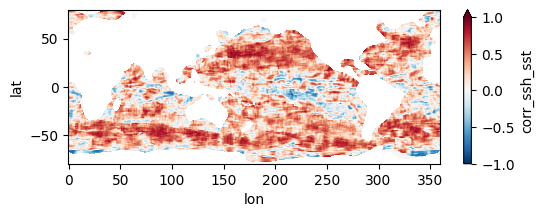

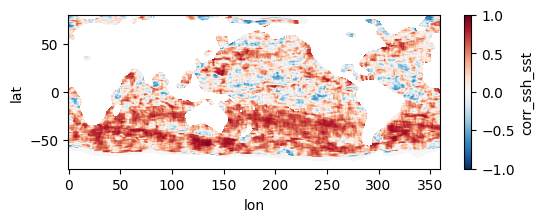

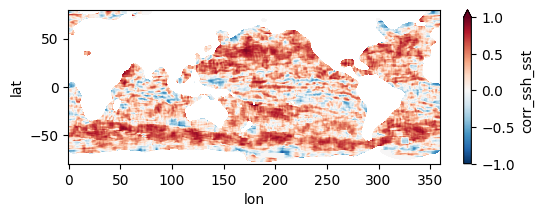

In [64]:
fns_results = [dir_results + f for f in os.listdir(dir_results) if f.endswith("nc")]
for fn in fns_results[:3]:
    testfile = xr.open_dataset(fn)
    testfile["corr_ssh_sst"].plot(figsize=(6,2), vmin=-1, vmax=1, cmap='RdBu_r')
    testfile.close()

**Colormap of mean correlation map for all files**

In [65]:
test_allfiles = xr.open_mfdataset(fns_results, combine='nested', concat_dim='dummy_time')
test_allfiles["corr_ssh_sst"]

<xarray.DataArray 'corr_ssh_sst' (dummy_time: 1808, lat: 641, lon: 1440)>
dask.array<concatenate, shape=(1808, 641, 1440), dtype=float64, chunksize=(1, 641, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 -80.0 -79.75 -79.5 -79.25 ... 79.25 79.5 79.75 80.0
Dimensions without coordinates: dummy_time

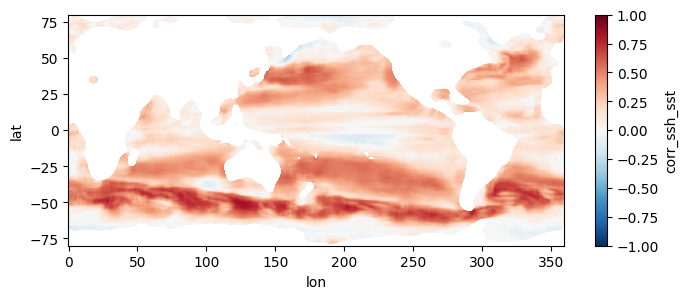

In [66]:
test_allfiles["corr_ssh_sst"].mean(dim='dummy_time').plot(figsize=(8,3), vmin=-1, vmax=1, cmap='RdBu_r')
test_allfiles.close()